In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
from astropy.coordinates import match_coordinates_sky, SkyCoord, Distance
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, Planck15

get_ipython().run_line_magic('matplotlib', 'inline')

Reading fits files and matching:

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

spt1 = Table.read('2500d_cluster_sample_Bocquet19.fits', format = 'fits')
spt2 = Table.read('sptecs_catalog_oct919.fits', format = 'fits')
spt = vstack([spt1, spt2], join_type='inner')
rm = Table.read('y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl50_catalog.fit', format = 'fits')

spt_id, spt_z = spt['SPT_ID'], spt['REDSHIFT']
spt_ra_dec = SkyCoord(ra = spt['RA'] * u.degree, dec = spt['DEC'] * u.degree, distance = Distance(z = spt_z, cosmology = cosmo))

rm_id, rm_z, rm_chisq = rm['MEM_MATCH_ID'], rm['Z_LAMBDA'], np.array(rm['LAMBDA_CHISQ'])
rm_ra_dec = SkyCoord(ra = rm['RA'] * u.degree, dec = rm['DEC'] * u.degree, distance = Distance(z = rm_z, cosmology = cosmo))


spt = QTable([spt_id, spt_ra_dec, spt_z], names = ('id', 'ra, dec', 'z'))
rm = QTable([rm_id, rm_ra_dec, rm_z], names = ('id', 'ra, dec', 'z'))


idx, sep2d, dist3d = match_coordinates_sky(rm['ra, dec'], spt['ra, dec']) #the order counts, len(rm)>>len(spt)
zdist = abs(spt['z'][idx]-rm['z'])

bln = (sep2d.arcmin < 10) & (zdist < 0.1)
matches_raw = {'rm_spt_ids':   np.column_stack((np.where(bln)[0], idx[bln])), 
               'sep2d_arcmin': sep2d[bln].arcmin, 
               'z':            rm['z'][bln], 
               'arcmin_to_mpc':  Planck15.arcsec_per_kpc_comoving(zdist[bln]).to(u.arcmin/u.Mpc).value }
rm_m_ids, spt_m_ids = matches_raw['rm_spt_ids'].T
rm_m_chisq = rm_chisq[bln]

matches = {'rm_spt_ids':[], 'sep2d_arcmin':[], 'z': [], 'dist_Mpc':[]}
for i in range(len(spt_m_ids)):
    result = np.where(spt_m_ids == spt_m_ids[i])[0]
    if len(result)==1:
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][result[0]]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][result[0]]) 
        matches['z'].append(matches_raw['z'][result[0]])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][result[0]]/matches_raw['arcmin_to_mpc'][result[0]])
    if len(result)>1:
        rm_new_m = rm_m_ids[result[np.where(np.array(rm_m_chisq[result]) == np.amax(np.array(rm_m_chisq[result])))]]
        new_id = np.where(matches_raw['rm_spt_ids'] == rm_new_m)[0][0]
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][new_id]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][new_id]) 
        matches['z'].append(matches_raw['z'][new_id])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][new_id]/matches_raw['arcmin_to_mpc'][new_id])        

spt_ids = np.array(matches['rm_spt_ids']).T[1]
spt_z_m = np.array(spt['z'][spt_ids])

offset = np.array(matches['dist_Mpc'])
offset_err = np.sqrt(np.sum(offset**2)/len(offset))

Plot:

(-10, 1119)

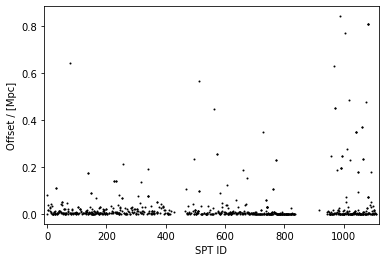

In [3]:
plt.errorbar(spt_ids, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT ID')
plt.xlim(-10, max(spt_ids) + 10)

Text(0.5, 0, 'SPT z')

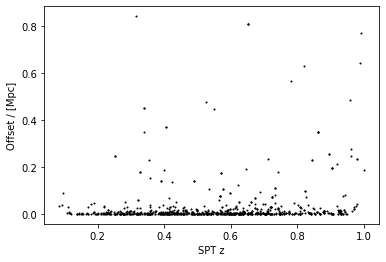

In [4]:
plt.errorbar(spt_z_m, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT z')

Text(0, 0.5, '$\\mathrm{N} / \\mathrm{N}_{tot}$')

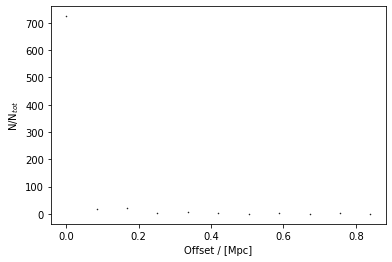

In [5]:
nbin = 10
bins = np.zeros((nbin) + 1)

bin_width = (max(offset) - min(offset)) / nbin
for i in range(len(offset)):
    bins[int(offset[i] / bin_width)] += 1
bins = bins

plt.plot(bin_width * range(len(bins)), bins, 'k.', ms = 1)
plt.xlabel(r'Offset / [Mpc]')
plt.ylabel(r'$\mathrm{N} / \mathrm{N}_{tot}$')

# Rayleigh Distribution:
$$P(x) = \frac{x}{\sigma^2}\mathrm{e}^{-0.5({x}/{\sigma})^2} \text{ and } \log(P(x)) = -2\log(\sigma) - \frac{x^2}{2\sigma ^2} + \log(x)$$



In [12]:
def log_prior(sigma):
    if np.all(sigma) > 0:
        return 0.0
    return -np.inf

def log_likelihood(sigma, x):
    log_l = np.sum(- 2 * np.log(sigma) - 0.5 * (x / sigma)**2 + np.log(x))
    return log_l

def log_posterior(sigma, x):
    log_prio = log_prior(sigma)
    if not np.isfinite(log_prio):
        return - np.inf
    log_like = log_likelihood(sigma, x)
    log_post = log_like + log_prio
    return log_post


import emcee

sigma_arr = offset_err + 0.1 * np.random.random((16, 1)) 

nwalkers, ndim = sigma_arr.shape


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[offset])
sampler.run_mcmc(sigma_arr, 2000, progress = True)

100%|██████████| 2000/2000 [00:17<00:00, 117.15it/s]


State([[0.07012916]
 [0.06890057]
 [0.07171957]
 [0.07043641]
 [0.07123898]
 [0.06929893]
 [0.07330528]
 [0.07079131]
 [0.07062092]
 [0.07160889]
 [0.07160175]
 [0.06793343]
 [0.06898842]
 [0.06878645]
 [0.07056553]
 [0.06868225]], log_prob=[-1196.45914648 -1197.16676089 -1196.9793716  -1196.43793039
 -1196.66059752 -1196.82518003 -1198.95245821 -1196.48756472
 -1196.45393141 -1196.89397942 -1196.88871955 -1198.46790982
 -1197.08192348 -1197.28508619 -1196.44688596 -1197.40119732], blobs=None, random_state=('MT19937', array([ 573923652, 3306940697, 2477072537, 3175128298, 1120209346,
       1846752764, 1895590485, 1357600378, 1358808625, 1722463569,
         74929140, 3765509371, 1355818675,  764661660, 4075428662,
        973432519, 1231271892, 3510633561, 4277136066, 1650294390,
       3867530887, 3417904189, 1402103940,  394239133, 1448380207,
       2518682947,  461483616, 4184465387, 4242443303,  324608727,
       1970656318, 4211121211,  387512351, 2960245687, 1341134759,
       

Tau =  [15.0870695]
Sigma_max_likelihood =  0.07026202319727605


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


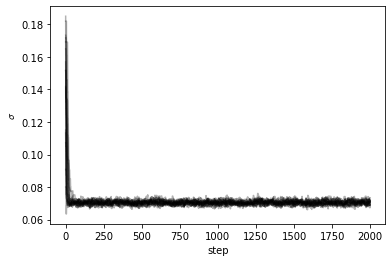

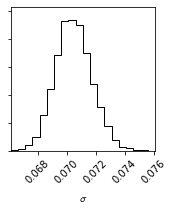

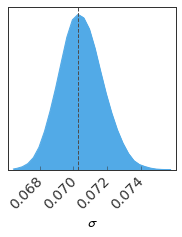

In [13]:
sample = sampler.get_chain()

label = [r'$\sigma$']
plt.plot(sample[:,:,0], "k", alpha=0.3)
plt.ylabel(label[0])
plt.xlabel('step')

tau = sampler.get_autocorr_time()
print('Tau = ', tau)
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_blob = sampler.get_blobs(flat=True,discard=100)

Max_likelihood = np.argmax(flat_blob)
sigma_ml = flat_samples[Max_likelihood,:][0]
print('Sigma_max_likelihood = ', sigma_ml)

import corner, pygtc
fig = corner.corner(flat_samples, labels=label)

GTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, 
                    holdRC = True, customLabelFont = {'size':14}, 
                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])

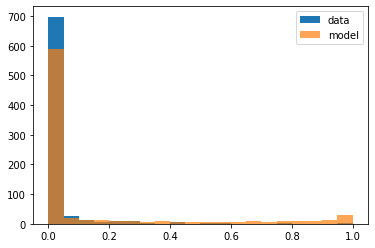

In [14]:
plt.hist(offset/max(offset), bins= 20, label = 'data')

x = np.linspace(min(offset), max(offset), len(offset))
y = x * np.exp(-0.5 * (x / sigma_ml)**2) / sigma_ml**2
plt.hist(y / max(y), alpha=0.7, bins=20, label = 'model')
plt.legend()

# 2 Rayleigh Distributions:
$$P(x|\sigma_0, \sigma_1, p_0) = x (\frac{p_0}{\sigma_0^2}\mathrm{e}^{-0.5({x}/{\sigma_0})^2} + \frac{1 - p_0}{\sigma_1^2}\mathrm{e}^{-0.5({x}/{\sigma_1})^2})$$


In [15]:
def log_prior2(theta):
    sigma_0, delta_sigma, p_0 = theta
    if sigma_0 > 0 and delta_sigma > 0 and 0 < p_0 < 1:
        return 0.0
    return -np.inf

def log_likelihood2(theta, x):
    sigma_0, delta_sigma, p_0 = theta
    sigma_1 = sigma_0 + delta_sigma
    log_l = np.sum(np.log(x * (p_0 * np.exp(- 0.5 * (x / sigma_0)**2) / (sigma_0**2) + (1 - p_0) * np.exp(- 0.5 * (x / sigma_1)**2) / (sigma_1**2))))
    return log_l

def log_posterior2(theta, x):
    log_prio = log_prior2(theta)
    if not np.isfinite(log_prio):
        return - np.inf
    log_like = log_likelihood2(theta, x)
    log_post = log_like + log_prio
    return log_post


sigma_arr2 = [0.1, 0.2, 0.5] + 1e-2 * np.random.random((16, 3))
nwalkers2, ndim2 = sigma_arr2.shape

sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior2, args=[offset])
sampler2.run_mcmc(sigma_arr2, 2000, progress = True)

  0%|          | 6/2000 [00:00<00:33, 59.29it/s]/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2000/2000 [00:22<00:00, 90.43it/s]


State([[0.002514   0.12679429 0.70263051]
 [0.00290788 0.12574101 0.74203381]
 [0.00255051 0.12703239 0.72499266]
 [0.0027846  0.13033837 0.73935386]
 [0.00265644 0.12483676 0.71598893]
 [0.0028583  0.12487837 0.72092297]
 [0.0024004  0.12549086 0.73240416]
 [0.00266971 0.12630818 0.70427008]
 [0.00282927 0.12996724 0.7403341 ]
 [0.00269497 0.13404569 0.69998553]
 [0.00273669 0.12198428 0.73919031]
 [0.00277808 0.12560293 0.69798256]
 [0.00270013 0.12684707 0.69594017]
 [0.00271379 0.12801913 0.69836896]
 [0.00258893 0.12665011 0.71490494]
 [0.00289457 0.13001112 0.70573212]], log_prob=[1756.72685918 1754.93342988 1756.59068692 1756.6621326  1757.04140681
 1755.58169658 1753.06996058 1757.0893284  1756.44487499 1756.49021268
 1754.82924478 1755.66900986 1756.51926021 1756.72049038 1757.23571516
 1755.44798229], blobs=None, random_state=('MT19937', array([ 573923652, 3306940697, 2477072537, 3175128298, 1120209346,
       1846752764, 1895590485, 1357600378, 1358808625, 1722463569,
      

(2000, 16, 3)


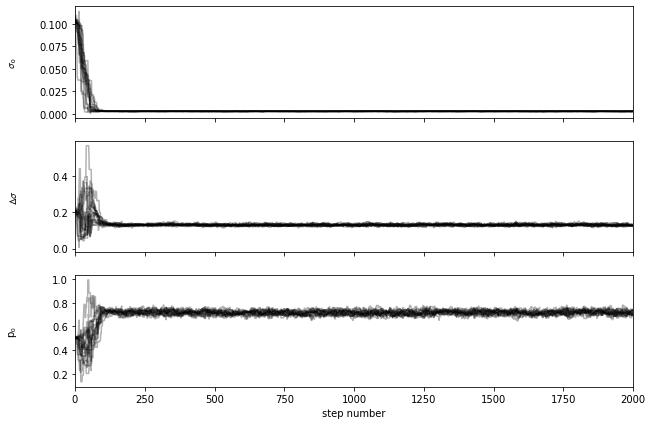

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain()

print(samples2.shape)
labels = ["$\sigma_0$", "$\Delta\sigma$", "p$_0$"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
flat_samples = sampler2.get_chain(discard=200, flat=True)
flat_blob = sampler2.get_blobs(flat=True,discard=200)

Max_likelihood2 = np.argmax(flat_blob)
par_ml = flat_samples[Max_likelihood2, :]
print(par_ml)

'''import corner, pygtc
fig = corner.corner(flat_samples, labels=label)

GTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, 
                    holdRC = True, customLabelFont = {'size':14}, 
                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])'''

[0.00269917 0.12832419 0.73231125]


"import corner, pygtc\nfig = corner.corner(flat_samples, labels=label)\n\nGTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, \n                    holdRC = True, customLabelFont = {'size':14}, \n                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])"

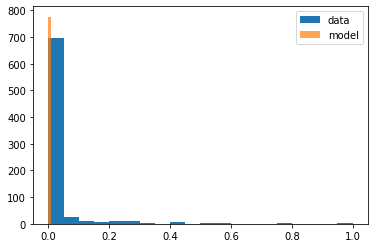

In [19]:
plt.hist(offset/max(offset), label = 'data', bins=20)

x = np.linspace(min(offset), max(offset), len(offset))
sigma_0, delta_sigma, p_0 = par_ml
sigma_1 = sigma_0 + delta_sigma
y = x * (p_0 * np.exp(- 0.5 * (x / sigma_0)**2) / (sigma_0**2) + (1 - p_0) * np.exp(- 0.5 * (x / sigma_1)**2) / (sigma_1**2))
plt.hist(y / max(y), alpha=0.7, label = 'model', bins=100)
plt.legend()